# 【PyTorch】Seq2Seqによる時系列予測

### 初期設定

In [1]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

#ランダムシードの設定
fix_seed = 2023
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

#デバイスの設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')

### データのロードと実験用の成形

In [2]:
class AirPassengersDataset(Dataset):
    def __init__(self, flag, seq_len, pred_len):
        #学習期間と予測期間の設定
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        #訓練用、評価用、テスト用を分けるためのフラグ
        type_map = {'train': 0, 'val': 1, 'test':2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        
        #seabornのデータセットから飛行機の搭乗者数のデータをロード
        df_raw = sns.load_dataset('flights')

        #訓練用、評価用、テスト用で呼び出すデータを変える
        border1s = [0, 12 * 9 - self.seq_len, 12 * 11 - self.seq_len]
        border2s = [12 * 9, 12 * 11, 12 * 12]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        data = df_raw[['passengers']].values
        
        ss = StandardScaler()
        data = ss.fit_transform(data)

        self.data = data[border1:border2]

    def __getitem__(self, index):
        #学習用の系列と予測用の系列を出力
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        src = self.data[s_begin:s_end]
        tgt = self.data[r_begin:r_end]

        return src, tgt
    
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

### DataLoaderの定義

In [3]:
def data_provider(flag, seq_len, pred_len, batch_size):
    #flagに合ったデータを出力
    data_set = AirPassengersDataset(flag=flag, 
                                    seq_len=seq_len, 
                                    pred_len=pred_len
                                   )
    #データをバッチごとに分けて出力できるDataLoaderを使用
    data_loader = DataLoader(data_set,
                             batch_size=batch_size, 
                             shuffle=True
                            )
    
    return data_loader

### Seq2Seqの定義

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, d_model, d_input, d_output, dropout = 0.1):
        super(Seq2Seq, self).__init__()
        
        #エンコーダのLSTM
        self.enc_lstm = nn.LSTM(d_input, d_model, batch_first=True, dropout=dropout)
        
        #デコーダのLSTM
        self.dec_lstm = nn.LSTM(d_output, d_model, batch_first=True, dropout=dropout)
        
        #全結合層
        self.output = nn.Linear(d_model, d_output)

    def forward(self, src, input_tgt):
        #hiddenとcontextのみ出力
        _, (h, c) = self.enc_lstm(src)
        
        #hiddenとcontextを用いてinput_tgtを予測
        output, _ = self.dec_lstm(input_tgt, (h, c))
        
        output = self.output(output)
        
        return output

### 訓練、評価の処理を定義

In [5]:
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for src, tgt in data_provider:
        #元データがintなのでfloatに変換
        src = src.float().to(device)
        tgt = tgt.float().to(device)
        
        #デコーダの入力
        input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)

        output = model(src=src, input_tgt=input_tgt)

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())

        optimizer.step()
        
    return np.average(total_loss)


def evaluate(flag, model, data_provider, criterion):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)
    
        #エンコーダから隠れ状態とセル状態を出力
        _, (h, c) = model.enc_lstm(src)
    
        #ループさせて次々に予測
        input_tgt = src[:,-1:,:].float().to(device)
        output = torch.Tensor().to(device)
    
        for i in range(tgt.size(1)):
        
            input_tgt, (h, c) = model.dec_lstm(input_tgt, (h, c))
            input_tgt = model.output(input_tgt)
        
            output = torch.cat((output, input_tgt), dim=1)
        
        loss = criterion(output, tgt)
        total_loss.append(loss.cpu().detach())
        
    if flag=='test':
        true = torch.cat((src, tgt), dim=1)
        pred = torch.cat((src, output), dim=1)
        plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
        plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
        plt.legend()
        plt.savefig('test.pdf')
        
    return np.average(total_loss)

def predict(model, data_provider, criterion):
    model.eval()
    #テスト用データは一つなのでforを使わず一つだけ出す
    src, tgt = data_provider.__iter__().next()
    src = src.float().to(device)
    tgt = tgt.float().to(device)
    
    _, (h, c) = model.enc_lstm(src)
    
    input_tgt = src[:,-1:,:].float().to(device)
    output = torch.Tensor().to(device)
    
    for i in range(tgt.size(1)):
        
        input_tgt, (h, c) = model.dec_lstm(input_tgt, (h, c))
        input_tgt = model.output(input_tgt)
        
        output = torch.cat((output, input_tgt), dim=1)
    
    #予測結果を画像にする
    true = torch.cat((src, tgt), dim=1)
    pred = torch.cat((src, output), dim=1)
    plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
    plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
    plt.legend()
    plt.savefig('test.pdf')
    
    return criterion(output, tgt)

### パラメータなどの定義

In [6]:
d_input = 1
d_output = 1
d_model = 512
dropout = 0.1
src_len = 36
tgt_len = 12
batch_size = 1
epochs = 100
best_loss = float('Inf')
best_model = None

model = Seq2Seq(
    d_model=d_model,
    d_input=d_input, d_output=d_output,
    dropout=dropout
)

#パラメータの初期化
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters())

### 訓練

In [7]:
for epoch in range(1, epochs + 1):
    
    #訓練
    loss_train = train(model=model, 
                       data_provider=data_provider('train', src_len, tgt_len, batch_size), 
                       optimizer=optimizer, 
                       criterion=criterion
                      )
    #評価
    loss_valid = evaluate(flag='val', 
                          model=model, 
                          data_provider=data_provider('val', src_len, tgt_len, batch_size), 
                          criterion=criterion
                         )
    
    
    if epoch%20==0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(
            epoch, epochs,
            loss_train, loss_valid,
        ))
    
    #評価用データに対する損失が最も小さいものを最も良いモデルとする
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model

[20/100] train loss: 0.02, valid loss: 0.06
[40/100] train loss: 0.01, valid loss: 0.15
[60/100] train loss: 0.00, valid loss: 0.06
[80/100] train loss: 0.00, valid loss: 0.08
[100/100] train loss: 0.00, valid loss: 0.06


### テスト用データにおける予測

0.22555654

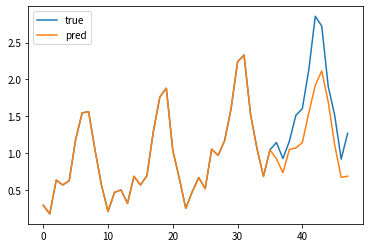

In [8]:
evaluate(flag='test', model=best_model, data_provider=data_provider('test', src_len, tgt_len, batch_size), criterion=criterion)